# Analyzing the Cryptocurrency market

Since the [launch of Bitcoin in 2008](https://newfronttest.bitcoin.com/bitcoin.pdf), hundreds of similar projects based on the blockchain technology have emerged. Cryptocurrencies are extremely valuable nowadays, and others may have the potential to become extremely valuable in the future. In fact, on the 6th of December of 2017, Bitcoin has a [market capitalization](https://en.wikipedia.org/wiki/Market_capitalization) above $200 billion.

![Bitcoin market capitalization](bitcoin_price.png)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'svg' 

current = pd.read_json('https://api.coinmarketcap.com/v1/ticker/')
current.head()

,24h_volume_usd,available_supply,id,last_updated,market_cap_usd,max_supply,name,percent_change_1h,percent_change_24h,percent_change_7d,price_btc,price_usd,rank,symbol,total_supply
0,1.512129e+10,17927175,bitcoin,1568120675,184767804476,2.100000e+07,Bitcoin,0.26,-0.92,-1.99,1.000000,10306.576718,1,BTC,17927175
1,6.461432e+09,107683843,ethereum,1568120661,19551418255,NaN,Ethereum,-0.05,-0.79,1.50,0.017632,181.563155,2,ETH,107683843
2,1.028244e+09,42984656144,ripple,1568120646,11323466365,1.000000e+11,XRP,0.74,0.45,0.83,0.000026,0.263430,3,XRP,99991362294
3,1.332750e+09,17995538,bitcoin-cash,1568120647,5529192625,2.100000e+07,Bitcoin Cash,0.29,-0.52,2.67,0.029838,307.253541,4,BCH,17995538
4,2.853052e+09,63224217,litecoin,1568120645,4507643986,8.400000e+07,Litecoin,0.19,1.15,4.23,0.006924,71.296162,5,LTC,63224217


The previous API call returns only the first 100 coins, and we want to explore as many coins as possible. Moreover, we can't produce reproducible analysis with live online data. To solve these problems, we will load a CSV we conveniently saved on the 6th of December of 2017 using the API call `https://api.coinmarketcap.com/v1/ticker/?limit=0` named `coinmarketcap_06122017.csv`

In [2]:
# Reading coinmarketcap_06122017.csv into pandas
dec6 = pd.read_csv('coinmarketcap_06122017.csv')

# Selecting the 'id' and the 'market_cap_usd' columns
market_cap_raw = dec6[['id', 'market_cap_usd']]

# Counting the number of values
market_cap_raw.count()

id                1326
market_cap_usd    1031
dtype: int64

Why do the `count()` for `id` and `market_cap_usd` differ above? It is because some cryptocurrencies listed in [coinmarketcap.com](coinmarketcap.com) have no known market capitalization, this is represented by `NaN` in the data, and `NaN`s are not counted by `count()`. These cryptocurrencies are of little interest to us in this analysis, so they are safe to remove.

In [3]:
# Filtering out rows without a market capitalization
cap = market_cap_raw.query('market_cap_usd > 0')

# Counting the number of values
cap.count()

id                1031
market_cap_usd    1031
dtype: int64

At the time of writing, Bitcoin is under serious competition from other projects, but it is still dominant in market capitalization. Let's plot the market capitalization for the top 10 coins as a barplot to better visualize this.

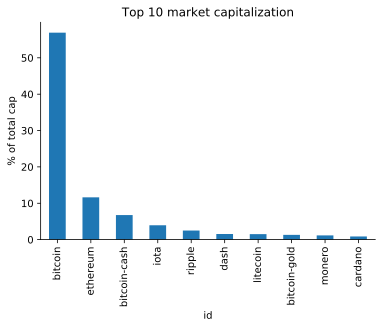

In [4]:
#Declaring these now for later use in the plots
TOP_CAP_TITLE = 'Top 10 market capitalization'
TOP_CAP_YLABEL = '% of total cap'

# Selecting the first 10 rows and setting the index
cap10 = cap.iloc[:10]
cap10.set_index('id', inplace=True)

# Calculating market_cap_perc
cap10 = cap10.assign(market_cap_perc = lambda x: x.market_cap_usd*100/cap.market_cap_usd.sum())

# Plotting the barplot with the title defined above 
ax = cap10.plot.bar(y='market_cap_perc', legend=False)
plt.title(TOP_CAP_TITLE)

# Hiding spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Annotating the y axis with the label defined above
_ = plt.ylabel(TOP_CAP_YLABEL)

While the plot above is informative enough, it can be improved. Bitcoin is too big, and the other coins are hard to distinguish because of this. Instead of the percentage, let's use a log<sup>10</sup> scale of the "raw" capitalization. Plus, let's use color to group similar coins and make the plot more informative.

For the colors rationale: bitcoin-cash and bitcoin-gold are forks of the bitcoin [blockchain](https://en.wikipedia.org/wiki/Blockchain). Ethereum and Cardano both offer Turing Complete [smart contracts](https://en.wikipedia.org/wiki/Smart_contract). Iota and Ripple are not minable. Dash, Litecoin, and Monero get their own color.

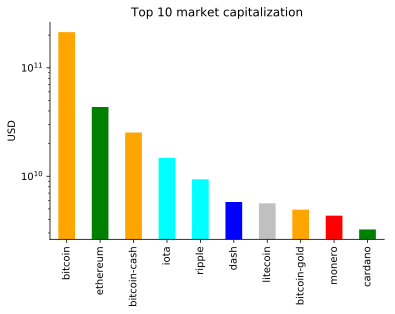

In [5]:
# Colors for the bar plot
COLORS = ['orange', 'green', 'orange', 'cyan', 'cyan', 'blue', 'silver', 'orange', 'red', 'green']

# Plotting market_cap_usd as before but adding the colors and scaling the y-axis  
ax = cap10.plot.bar(y='market_cap_usd', color=COLORS, logy=True, legend=False)

# Annotating the y axis with 'USD'
plt.ylabel('USD')
plt.title(TOP_CAP_TITLE)

# Hiding spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Removing the xlabel as it is not very informative
_ = plt.xlabel('')

The cryptocurrencies market has been spectacularly volatile since the first exchange opened. Let's explore this volatility a bit more! We will begin by selecting and plotting the 24 hours and 7 days percentage change, which we already have available.

In [6]:
# Selecting the id, percent_change_24h and percent_change_7d columns
volatility = dec6[['id', 'percent_change_24h', 'percent_change_7d']]

# Setting the index to 'id' and dropping all NaN rows
volatility = volatility.set_index('id').dropna()

# Sorting the DataFrame by percent_change_24h in ascending order
volatility = volatility.sort_values('percent_change_24h')
volatility.head()

,percent_change_24h,percent_change_7d
id,,
flappycoin,-95.85,-96.61
credence-coin,-94.22,-95.31
coupecoin,-93.93,-61.24
tyrocoin,-79.02,-87.43
petrodollar,-76.55,542.96


It seems you can lose a lot of money quickly on cryptocurrencies. Let's plot the top 10 biggest gainers and top 10 losers in market capitalization.

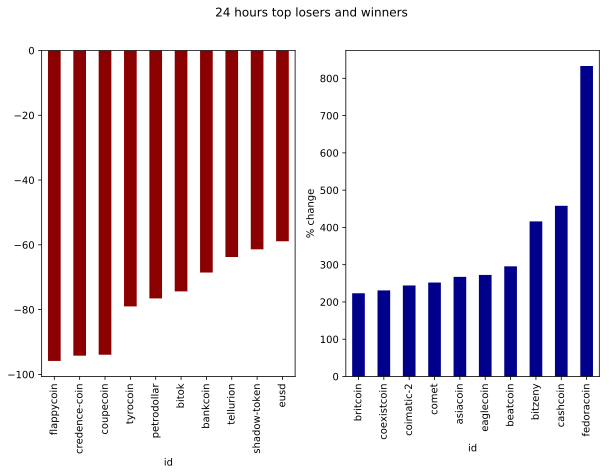

In [7]:
def top10_subplot(volatility_series, title):
    # Making the subplot and the figure for two side by side plots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
    
    # Plotting with pandas the barchart for the top 10 losers
    ax = volatility_series[:10].plot.bar(ax=axes[0], color='darkred')
    
    # Setting the figure's main title to the text passed as parameter
    fig.suptitle(title)
    
    # Setting the ylabel to '% change'
    plt.ylabel('% change')
    
    # Same as above, but for the top 10 winners
    ax = volatility_series[-10:].plot.bar(ax=axes[1], color='darkblue')
    
    # Returning this for good practice, might use later
    return fig, ax

DTITLE = "24 hours top losers and winners"

fig, ax = top10_subplot(volatility.percent_change_24h, DTITLE)

Let's see what is going weekly instead of daily. Please note the implications of the red plots on how much value some cryptocurrencies lose in such short periods of time

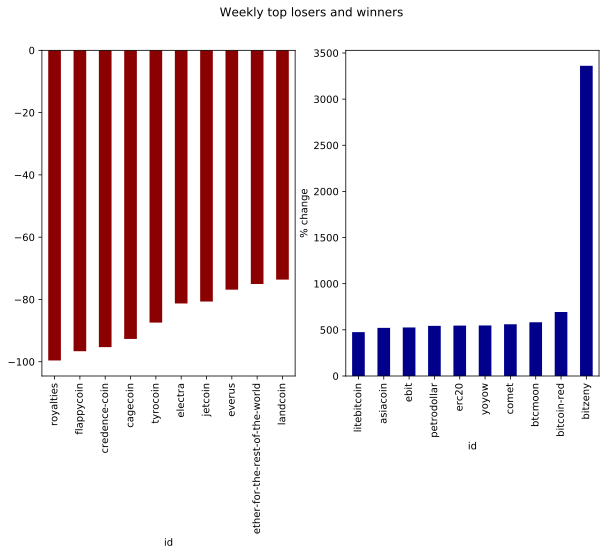

In [8]:
# Sorting in ascending order
volatility7d = volatility.sort_values('percent_change_7d')

WTITLE = "Weekly top losers and winners"

fig, ax = top10_subplot(volatility7d.percent_change_7d, WTITLE)

The names of the cryptocurrencies above are quite unknown, and there is a considerable fluctuation between the 1 and 7 days percentage changes. As with stocks, and many other financial products, the smaller the capitalization, the bigger the risk and reward. Smaller cryptocurrencies are less stable projects in general, and therefore even riskier investments than the bigger ones. Let's classify our dataset based on Investopedia's capitalization [definitions](https://www.investopedia.com/video/play/large-cap/) for company stocks.

In [9]:
# Selecting everything bigger than 10 billion 
largecaps = cap.query('market_cap_usd > 10 ** 10')
largecaps

,id,market_cap_usd
0,bitcoin,2.130493e+11
1,ethereum,4.352945e+10
2,bitcoin-cash,2.529585e+10
3,iota,1.475225e+10


Note that many coins are not comparable to large companies in market cap, so let's divert from the original Investopedia definition by merging categories.

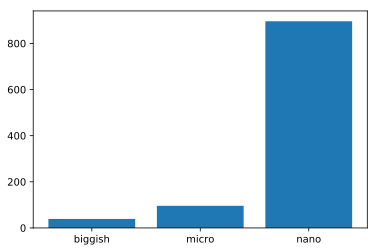

In [10]:
# Making a nice function for counting different marketcaps from the
# "cap" DataFrame. Returns an int.
def capcount(query_string):
    return cap.query(query_string).count().id

# Labels for the plot
LABELS = ["biggish", "micro", "nano"]

# Using capcount count the biggish cryptos
biggish = capcount('market_cap_usd > 300 * 10**6')

# Same as above for micro ...
micro = capcount('50 * 10**6 < market_cap_usd < 300 * 10**6')

# ... and for nano
nano =  capcount('50 * 10**6 > market_cap_usd')

# Making a list with the 3 counts
values = [biggish, micro, nano]

# Plotting them with matplotlib 
_ = plt.bar(x=LABELS, height=values)